# Explore here

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima



In [3]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
df = pd.read_csv(url)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
df.dtypes

date      object
sales    float64
dtype: object

In [5]:
df.shape

(366, 2)

In [6]:
df.duplicated().sum

<bound method Series.sum of 0      False
1      False
2      False
3      False
4      False
       ...  
361    False
362    False
363    False
364    False
365    False
Length: 366, dtype: bool>

In [7]:
df.date = pd.to_datetime(df.date)
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [8]:
(df.date.max()-df.date.min()).days

365

In [9]:
df.date.nunique()

366

In [10]:
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


No hay valores faltantes en las fechas

In [11]:
ts_sales = df.sales

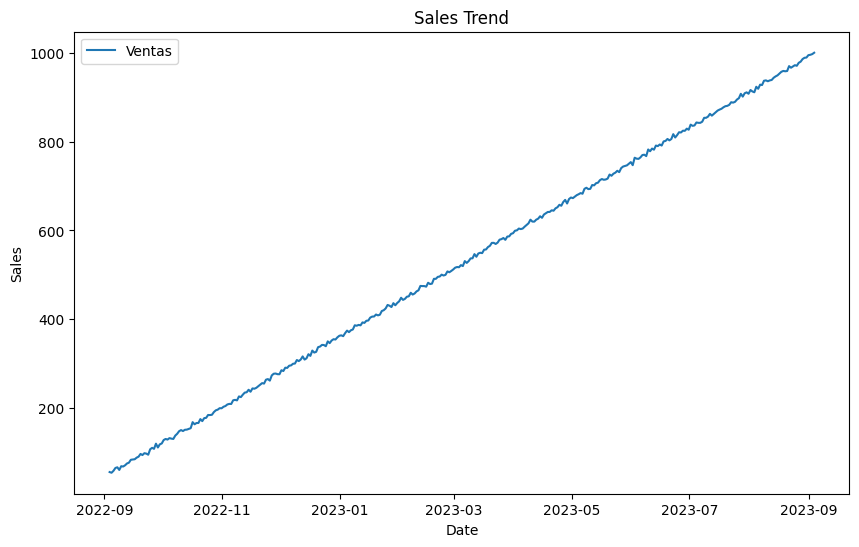

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df.date, ts_sales, label="Ventas")
plt.title("Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

We will now descompose the time series to analyse trend, seasonability and noise.

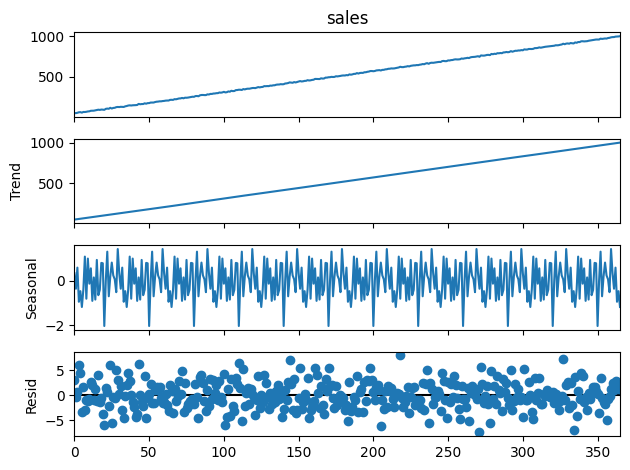

In [13]:
decomposition = seasonal_decompose(ts_sales, model='additive', period=30, extrapolate_trend='freq')

# We extract the components of the decomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()


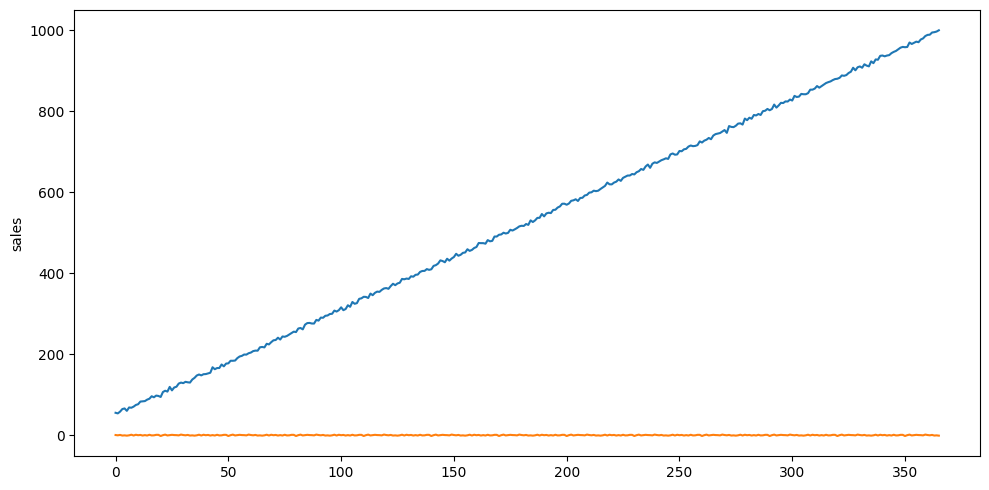

In [14]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_sales)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [15]:
def test_stationarity(timeseries):
    print("Dickey-Fuller Test Results:")
    adf_test = adfuller(timeseries, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations'])
    
    # Show the critical values for different significance levels
    for key, value in adf_test[4].items():
        results[f"Critical Value ({key})"] = value

    return results

In [16]:
stationarity_results = test_stationarity(ts_sales)  
print(stationarity_results)

Dickey-Fuller Test Results:
Test Statistic              0.545414
p-value                     0.986190
#Lags Used                 13.000000
Number of Observations    352.000000
Critical Value (1%)        -3.449065
Critical Value (5%)        -2.869786
Critical Value (10%)       -2.571163
dtype: float64


In [17]:
# We use the test Dickey-Fuller. If the p-value is above 0.05, it will not be considered stationary.
if stationarity_results['p-value'] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

The time series is not stationary.


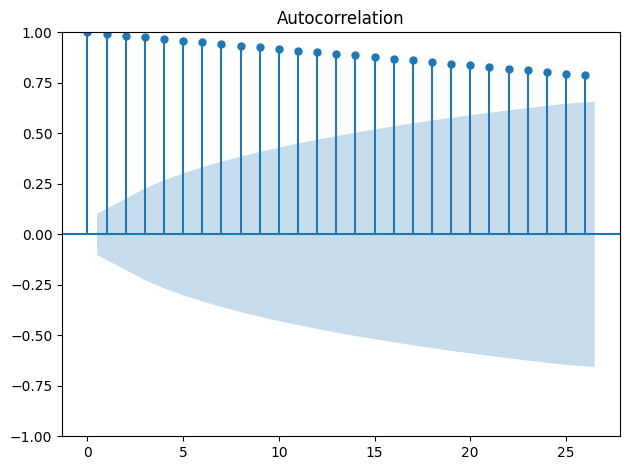

In [18]:
# We will finish by doing a correlation analysis.

plot_acf(ts_sales)

plt.tight_layout()

plt.show()

There is a slow decay, for they are gradually decreasing, but remain significantly positive for at least 25 lags, which implies there is likely a trend.

We finish by performing the ARIMA.

In [19]:
model = auto_arima(ts_sales, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1847.128, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1972.853, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1844.646, Time=1.02 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1843.274, Time=0.44 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=0.96 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1843.586, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1841.532, Time=0.31 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1843.435, Time=1.18 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=0.92 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1839.552, Time=0.20 sec
 ARIMA(1,1,1)(1,0,0)[12] inte

We will now do a prediction with the trained model.

In [22]:
forecast = model.predict(100)
forecast

366    1002.158148
367    1004.831668
368    1007.423289
369    1010.021630
370    1012.619419
          ...     
461    1249.022047
462    1251.619878
463    1254.217709
464    1256.815540
465    1259.413371
Length: 100, dtype: float64

We will now plot the known data from ts_sales in blue and we will display in red the forecasted data.

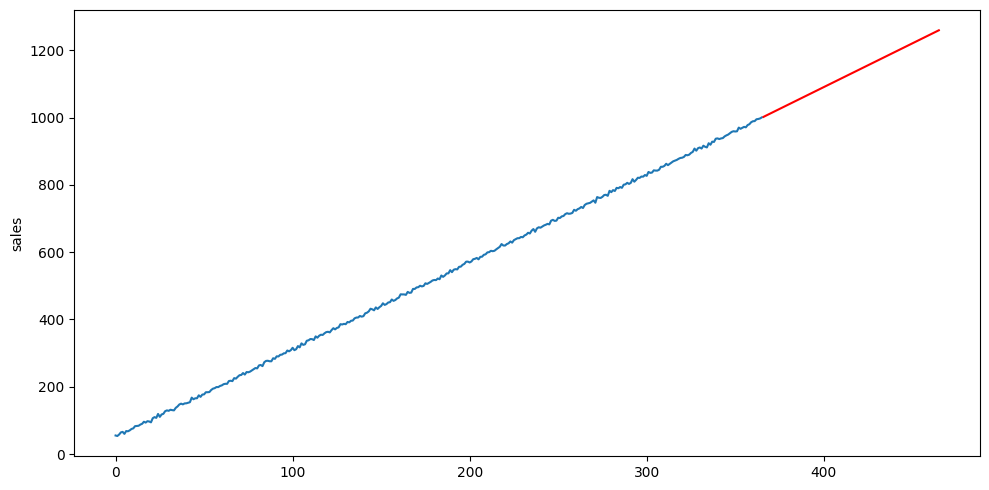

In [25]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_sales)
sns.lineplot(data = forecast, c = "red")

plt.tight_layout()

plt.show()